In [1]:
import pandas as pd
'''
Read Data to get asset names
'''
file_path = "CBdata.xlsx"
xls = pd.read_excel(file_path, sheet_name=None, header=None,engine='openpyxl')
Name_df = xls["NaME"]

import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
import scipy.stats as stats
import warnings
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

The data we would use here:  

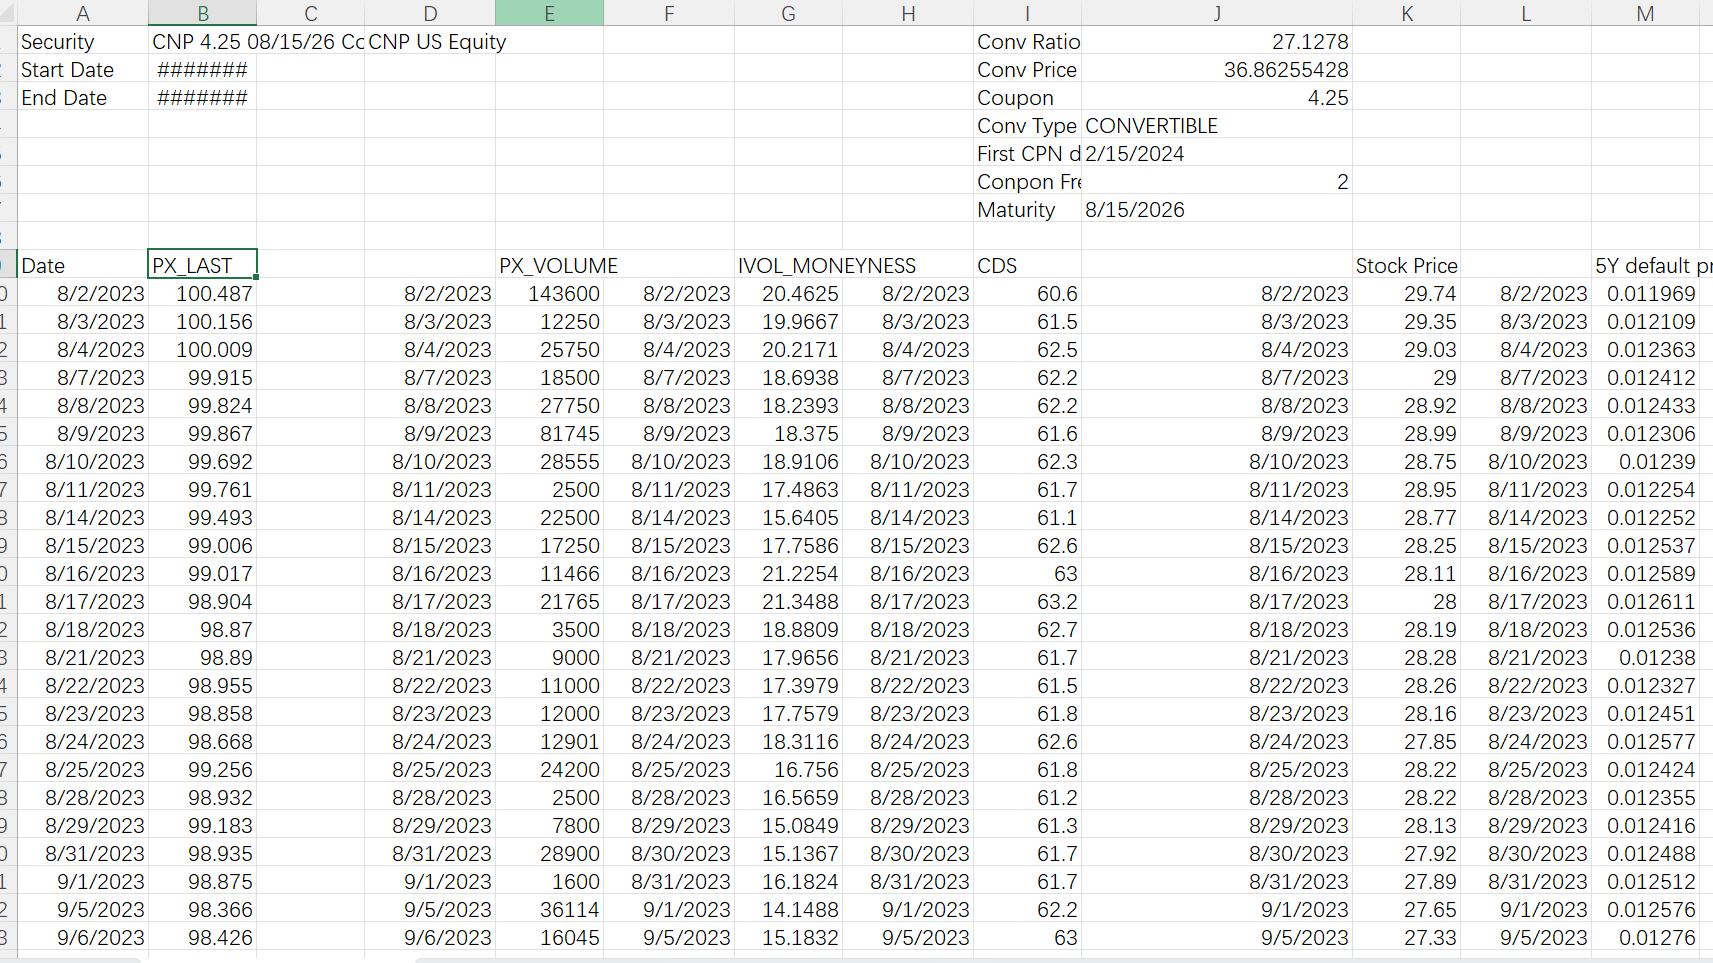

In [2]:
import tqdm
from functions import explicit_FD
from functions import find_between

RMSEs = []
# iterate asset names
for i in tqdm.tqdm(range(len(Name_df))):
    sheetname=Name_df.iloc[i,0].replace("/", " ")
    d=Name_df.iloc[i,1] # dividend
    CB_df=xls[sheetname] # sheetname --> data

    # extract parameters
    CR=CB_df.iloc[0,9]     # conversion ratio
    CP=CB_df.iloc[1,9]     # conversion price
    Coupon=CB_df.iloc[2,9]/100
    FCP=pd.to_datetime(CB_df.iloc[4,9]) # first coupon payment
    CFQ=CB_df.iloc[5,9]     # Coupon Frequency
    M=pd.to_datetime(CB_df.iloc[6,9])   # Maturity date
    call_date = CB_df.iloc[0,12]
    call_price = CB_df.iloc[1,12]
    put_date = CB_df.iloc[2,12]
    put_price = CB_df.iloc[3,12]

    # Data Processing
    Price_df= CB_df.iloc[9:, 0:2].dropna()
    IVOL_df=CB_df.iloc[9:, 5:7].dropna()
    CDS_df=CB_df.iloc[9:, 7:9].dropna()
    S_df=CB_df.iloc[9:, 9:11].dropna()
    Price_df= Price_df.rename(columns={0: "date", 1: 'bond_price'})
    CDS_df= CDS_df.rename(columns={7: "date", 8: 'CDS'})
    IVOL_df= IVOL_df.rename(columns={5: "date", 6: 'IVOL'})
    S_df= S_df.rename(columns={9: "date", 10: 'S'})
    Price_df['date'] = pd.to_datetime(Price_df['date'])
    IVOL_df['date'] = pd.to_datetime(IVOL_df['date'])
    CDS_df['date'] = pd.to_datetime(CDS_df['date'])
    S_df['date'] = pd.to_datetime(S_df['date'])
    # Merge all data together (CBprice,IV,CDS,StockPrice)
    Price_df = pd.merge(Price_df, IVOL_df, on="date", how='inner')
    Price_df = pd.merge(Price_df, CDS_df, on="date", how='inner')
    Price_df = pd.merge(Price_df, S_df, on="date", how='inner')

    # Interplotation of Risk Free Rates in Different Periods
    r_df=xls['R'].rename(columns={0: "date"}).iloc[1:,:]
    r_df['date'] = pd.to_datetime(r_df['date']) 
    Price_df = pd.merge(Price_df, r_df, on="date", how='inner')
    Price_df =Price_df .dropna()
    if len(Price_df)<2:
        print(i)

    # rate interplotation and simulate price
    rlist=[1/12,1/6,1/4,1/2,1,2,3,5,7,10,20,30]
    SimulatePrice=[]
    for j in tqdm.tqdm(range(len(Price_df))):
        date1,v,CDS,S=Price_df.iloc[j,0],Price_df.iloc[j,2],Price_df.iloc[j,3],Price_df.iloc[j,4]
        T = (M - date1).days
        CPT=(FCP - date1).days%(360/CFQ)/T
        Year=T/360
        rlow,rhigh=find_between(rlist,Year)
        r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
        

        # if there's no call provision or call provision passed, don't consider it
        if pd.isna(call_date):
            call_price = -1 
        else:
            if date1 < call_date:
                call_price = -1
        # if there's no call provision or call provision passed, don't consider it
        if pd.isna(put_date):
            put_price = -1 
        else:
            if date1 < put_date:
                put_price = -1

        a=explicit_FD(100,Year,v/100,r,d,CDS/10000,CP,Coupon,CFQ,CPT,700,15000,call_price,put_price,S)

        SimulatePrice.append(a)

    # save results
    df = pd.DataFrame(SimulatePrice, columns=['ModelPrice'])
    Price_df = pd.concat([Price_df, df], axis=1)
    Price_df['RelativeDifference']=Price_df['ModelPrice']/Price_df['bond_price']-1
    
    RMSE = np.sqrt(np.mean(Price_df[Price_df['RelativeDifference']<1]['RelativeDifference']**2))
    print('RMSE:')
    print(RMSE)
    RMSEs.append(RMSE)
    
    Price_df.to_excel('TF results with call and put/'+sheetname+'.xlsx', index=False)
    

  0%|          | 0/85 [00:00<?, ?it/s]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 788/788 [05:36<00:00,  2.34it/s]


RMSE:
0.1792419121266742


  1%|          | 1/85 [05:36<7:51:34, 336.84s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar add
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
  2%|▏         | 2/85 [08:48<5:47:51, 251.46s/it]

RMSE:
0.32077148319094584


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1041/1041 [09:40<00:00,  1.79it/s]


RMSE:
0.7426429633139724


  4%|▎         | 3/85 [18:29<9:09:17, 401.92s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 684/684 [18:50<00:00,  1.65s/it]


RMSE:
0.10040135326112248


  5%|▍         | 4/85 [37:19<15:30:49, 689.50s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 904/904 [11:26<00:00,  1.32it/s]


RMSE:
0.3243166278648528


  6%|▌         | 5/85 [48:46<15:18:07, 688.59s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 631/631 [07:52<00:00,  1.33it/s]


RMSE:
0.10021562145637866


  7%|▋         | 6/85 [56:40<13:30:15, 615.39s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 179/179 [02:15<00:00,  1.32it/s]


RMSE:
0.02277898786151328


  8%|▊         | 7/85 [58:55<9:56:01, 458.48s/it] C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 410/410 [05:04<00:00,  1.35it/s]


RMSE:
0.2963479001837727


 11%|█         | 9/85 [1:04:14<6:02:14, 285.98s/it]

RMSE:
0.13465402348456304


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 903/903 [07:09<00:00,  2.10it/s]


RMSE:
0.2789384104620481


 12%|█▏        | 10/85 [1:11:24<6:52:58, 330.38s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 954/954 [05:29<00:00,  2.89it/s]


RMSE:
0.3532197520862265


 14%|█▍        | 12/85 [1:17:18<4:48:23, 237.03s/it]

RMSE:
0.04828537891971042


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 15%|█▌        | 13/85 [1:19:41<4:10:26, 208.70s/it]

RMSE:
0.49228075090887435


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 16%|█▋        | 14/85 [1:21:56<3:40:21, 186.22s/it]

RMSE:
nan


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 901/901 [05:27<00:00,  2.75it/s]


RMSE:
0.2936150808914743


 18%|█▊        | 15/85 [1:27:24<4:27:16, 229.10s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1041/1041 [06:26<00:00,  2.70it/s]


RMSE:
0.9115045131375122


 19%|█▉        | 16/85 [1:33:51<5:17:59, 276.51s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 748/748 [04:26<00:00,  2.80it/s]


RMSE:
0.5636569729888539


 21%|██        | 18/85 [1:39:17<3:53:36, 209.20s/it]

RMSE:
0.06696645734792069


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 22%|██▏       | 19/85 [1:41:47<3:30:45, 191.60s/it]

RMSE:
0.09261425325501746


 24%|██▎       | 20/85 [1:41:48<2:25:33, 134.36s/it]

RMSE:
0.005483020439227492


 25%|██▍       | 21/85 [1:41:51<1:41:09, 94.84s/it] 

RMSE:
0.05199994846740998


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 999/999 [37:54<00:00,  2.28s/it]


RMSE:
0.33399116584451255


 27%|██▋       | 23/85 [2:19:54<9:04:12, 526.66s/it] 

RMSE:
0.22069898616324715
23


0it [00:00, ?it/s]


RMSE:
nan


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 904/904 [05:08<00:00,  2.93it/s]


RMSE:
0.29315427194319454


100%|██████████| 653/653 [05:54<00:00,  1.84it/s]it]


RMSE:
0.17582175859839988


 31%|███       | 26/85 [2:30:58<5:49:02, 354.96s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 634/634 [03:32<00:00,  2.98it/s]


RMSE:
0.10107745295938518


 32%|███▏      | 27/85 [2:34:31<5:07:15, 317.85s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 726/726 [04:14<00:00,  2.86it/s]


RMSE:
0.9258329190230917


 33%|███▎      | 28/85 [2:38:45<4:45:32, 300.57s/it]

28


0it [00:00, ?it/s]


RMSE:
nan


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1041/1041 [05:52<00:00,  2.96it/s]


RMSE:
0.39206513055658343


100%|██████████| 464/464 [02:38<00:00,  2.94it/s]it]


RMSE:
0.29870529218478453


 38%|███▊      | 32/85 [2:48:15<2:41:43, 183.09s/it]

RMSE:
1.0


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 831/831 [04:32<00:00,  3.05it/s]


RMSE:
0.34590210469458205


 40%|████      | 34/85 [2:52:57<2:09:29, 152.34s/it]

RMSE:
0.022762094444330055


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 41%|████      | 35/85 [2:54:30<1:53:08, 135.77s/it]

RMSE:
0.1918807273130869


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:53<00:00,  2.95it/s]


RMSE:
0.18006569485356516


 44%|████▎     | 37/85 [3:01:04<2:01:52, 152.34s/it]

RMSE:
0.1282406757135255


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 775/775 [04:09<00:00,  3.10it/s]


RMSE:
0.12628651231509824


 45%|████▍     | 38/85 [3:05:15<2:21:50, 181.07s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 801/801 [04:27<00:00,  3.00it/s]


RMSE:
0.2253100096649479


 46%|████▌     | 39/85 [3:09:42<2:38:24, 206.62s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar add
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [17:24<00:00,  1.00s/it]


RMSE:
nan


100%|██████████| 226/226 [01:57<00:00,  1.92it/s]it]


RMSE:
0.23064131771018312


 48%|████▊     | 41/85 [3:29:05<4:20:18, 354.97s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [08:50<00:00,  1.97it/s]


RMSE:
0.21886516444999374


 49%|████▉     | 42/85 [3:37:56<4:52:01, 407.47s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 215/215 [01:14<00:00,  2.89it/s]


RMSE:
0.01630237075402864


 51%|█████     | 43/85 [3:39:11<3:35:37, 308.04s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 727/727 [04:20<00:00,  2.79it/s]


RMSE:
0.2790774488939283


 53%|█████▎    | 45/85 [3:43:54<2:21:51, 212.79s/it]

RMSE:
0.031959490352968654


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 885/885 [04:52<00:00,  3.02it/s]


RMSE:
0.32180946679644346


 54%|█████▍    | 46/85 [3:48:48<2:33:59, 236.92s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1001/1001 [15:18<00:00,  1.09it/s]


RMSE:
0.35936373010875305


 56%|█████▋    | 48/85 [4:06:34<3:37:52, 353.32s/it]

RMSE:
0.10173847663832668


 58%|█████▊    | 49/85 [4:07:27<2:37:58, 263.29s/it]

RMSE:
0.03171196057731679


 59%|█████▉    | 50/85 [4:08:29<1:58:16, 202.75s/it]

RMSE:
0.024446392085332044


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 60%|██████    | 51/85 [4:10:42<1:43:08, 182.02s/it]

RMSE:
0.29184704732119165


 61%|██████    | 52/85 [4:10:58<1:12:35, 131.99s/it]

RMSE:
nan


 62%|██████▏   | 53/85 [4:11:30<54:30, 102.20s/it]  

RMSE:
0.29531151976801007


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 904/904 [05:30<00:00,  2.74it/s]


RMSE:
0.19085477781500895


 64%|██████▎   | 54/85 [4:17:01<1:28:10, 170.67s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 690/690 [03:43<00:00,  3.09it/s]


RMSE:
0.09778728550417293


 65%|██████▍   | 55/85 [4:20:45<1:33:18, 186.62s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:29<00:00,  3.17it/s]


RMSE:
0.11025962820415285


 67%|██████▋   | 57/85 [4:26:29<1:17:02, 165.09s/it]

RMSE:
nan


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1041/1041 [05:48<00:00,  2.99it/s]


RMSE:
0.26531647489335386


 68%|██████▊   | 58/85 [4:32:18<1:39:04, 220.15s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 757/757 [04:28<00:00,  2.82it/s]


RMSE:
0.3996821174024256


 69%|██████▉   | 59/85 [4:36:47<1:41:44, 234.79s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 659/659 [03:55<00:00,  2.80it/s]


RMSE:
0.1776956319840466


 72%|███████▏  | 61/85 [4:41:46<1:13:28, 183.69s/it]

RMSE:
0.14625664684324322


 73%|███████▎  | 62/85 [4:42:33<54:39, 142.59s/it]  

RMSE:
0.2016883651760451


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 608/608 [03:27<00:00,  2.93it/s]


RMSE:
0.24144643537988447


 74%|███████▍  | 63/85 [4:46:01<59:27, 162.14s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 973/973 [05:20<00:00,  3.04it/s]


RMSE:
0.45129752306061127


 75%|███████▌  | 64/85 [4:51:22<1:13:25, 209.77s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1043/1043 [05:39<00:00,  3.07it/s]


RMSE:
0.13523470285196537


 76%|███████▋  | 65/85 [4:57:01<1:22:54, 248.74s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:28<00:00,  3.18it/s]


RMSE:
0.06413061173911822


 79%|███████▉  | 67/85 [5:02:44<58:30, 195.03s/it]  

RMSE:
1.0


 80%|████████  | 68/85 [5:03:34<42:56, 151.55s/it]

RMSE:
0.06666092412216708


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 752/752 [04:05<00:00,  3.06it/s]


RMSE:
0.12454637920679389


 81%|████████  | 69/85 [5:07:40<47:59, 179.96s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1029/1029 [2:26:53<00:00,  8.56s/it]


RMSE:
0.17264517668963753


 84%|████████▎ | 71/85 [7:35:21<7:35:44, 1953.18s/it] 

RMSE:
0.31956805554281076


 85%|████████▍ | 72/85 [7:37:01<5:02:43, 1397.23s/it]

RMSE:
0.10387432535253265


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [06:00<00:00,  2.89it/s]


RMSE:
0.12953194949226104


 86%|████████▌ | 73/85 [7:43:02<3:37:17, 1086.44s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:58<00:00,  2.91it/s]


RMSE:
0.6360896890383212


100%|██████████| 1043/1043 [06:20<00:00,  2.74it/s]] 


RMSE:
0.14843118979641168


 88%|████████▊ | 75/85 [7:55:22<2:00:21, 722.11s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 89%|████████▉ | 76/85 [7:58:24<1:23:59, 560.00s/it]

RMSE:
0.2673929258874969


 91%|█████████ | 77/85 [8:01:10<58:54, 441.84s/it]  

RMSE:
0.23475509489982935


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1043/1043 [05:36<00:00,  3.10it/s]


RMSE:
0.0800020090021461


 93%|█████████▎| 79/85 [8:07:12<29:28, 294.77s/it]

RMSE:
0.19136112382127943


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 616/616 [03:19<00:00,  3.09it/s]


RMSE:
0.1484028416251646


 94%|█████████▍| 80/85 [8:10:32<22:11, 266.35s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:31<00:00,  3.15it/s]


RMSE:
0.15055932943227496


 95%|█████████▌| 81/85 [8:16:04<19:03, 285.99s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 1044/1044 [05:54<00:00,  2.95it/s]


RMSE:
0.094124519215457


 96%|█████████▋| 82/85 [8:21:59<15:19, 306.63s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 908/908 [04:57<00:00,  3.05it/s]


RMSE:
0.09456386988063634


 98%|█████████▊| 83/85 [8:26:57<10:08, 304.12s/it]C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
 99%|█████████▉| 84/85 [8:28:00<03:51, 231.88s/it]

RMSE:
0.030294175189168365


C:\Users\cj dong\AppData\Local\Temp\ipykernel_11364\3538517153.py:59: RuntimeWarning: invalid value encountered in scalar divide
  r=((Year-rlow)*Price_df.iloc[j,int(rlist.index(rlow))+5]/(rhigh-rlow)+(rhigh-Year)*Price_df.iloc[j,int(rlist.index(rhigh))+5]/(rhigh-rlow))/100
100%|██████████| 85/85 [8:28:46<00:00, 359.13s/it]

RMSE:
0.016083594919936006


IF you want to test one bond, here: